In [1]:
!pip install bertopic

  Using cached bertopic-0.17.3-py3-none-any.whl.metadata (24 kB)
  Using cached umap_learn-0.5.9.post2-py3-none-any.whl.metadata (25 kB)
  Using cached plotly-6.5.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached sentence_transformers-5.1.2-py3-none-any.whl.metadata (16 kB)
  Using cached narwhals-2.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
Using cached bertopic-0.17.3-py3-none-any.whl (153 kB)
   ---------------------------------------- 0.0/730.9 kB ? eta -:--:--
   --------------------------------------- 730.9/730.9 kB 15.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------- ----------------------------- 10.5/38.1 MB 72.5 MB/s eta 0:00:01
   --------------------- ------------------ 21.0/38.1 MB 50.9 MB/s eta 0:00:01
   ----------------------------------- ---- 34.1/38.1 MB 54.1 MB/s eta 0:00:01
   ---------------------------------------- 38.1/38.1 MB 50.5 MB/s eta 0:00:


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# 1. 데이터 불러오기
DATA_PATH = "../data/03_final/final_result.csv"
df = pd.read_csv(DATA_PATH)

print("전체 데이터 로드 완료:", len(df))
print(df['category'].value_counts())

# ---------------------------------------------------------
# 🎯 전략 수정: 데이터가 풍부한 '진정/트러블'을 분석합니다.
# 라벨 3(부작용)이 너무 적어서, 라벨 1(진정/트러블)에서 인사이트를 찾습니다.
# ---------------------------------------------------------
TARGET_LABEL = 1

# 선택한 라벨의 리뷰만 필터링
target_reviews = df[df['predicted_label'] == TARGET_LABEL]['cleaned_review'].dropna().tolist()

print(f"\n✅ 분석 대상(라벨 {TARGET_LABEL} - 진정/트러블) 리뷰 개수: {len(target_reviews)}개")
print("👉 '진정' 관련 리뷰에서 구체적으로 어떤 고민(좁쌀, 붉은기 등)이 있는지 분석합니다.")

전체 데이터 로드 완료: 92559
category
보습/수분     40524
진정/트러블    27326
기타        16887
사용감/흡수     7822
Name: count, dtype: int64

✅ 분석 대상(라벨 1 - 진정/트러블) 리뷰 개수: 27326개
👉 '진정' 관련 리뷰에서 구체적으로 어떤 고민(좁쌀, 붉은기 등)이 있는지 분석합니다.


In [5]:
print("토픽 모델링 시작... (시간이 좀 걸립니다 ⏳)")

# 1. 불용어(분석에서 뺄 단어) 설정
# "너무", "진짜" 같이 의미 없는 단어는 빼야 결과가 깔끔합니다.
stopwords = [
    '너무', '진짜', '정말', '많이', '그냥', '아주', '좀', '잘', '하고', '다',
    '바르고', '좋아요', '같아요', '있어서', '근데', '그래서', '쓰고', '제품',
    '구매', '사용', '피부', '크림', '바르면', '있는', '합니다', '거', '게',
    '한', '더', '제', '수', '이거', '보고', '또'
]

vectorizer_model = CountVectorizer(tokenizer=None, stop_words=stopwords)

# 2. 모델 생성 및 학습
# min_topic_size: 토픽 하나당 최소 리뷰 수 (데이터가 많으니 30~50 추천)
topic_model = BERTopic(
    language="multilingual", # 한국어 지원
    vectorizer_model=vectorizer_model,
    nr_topics="auto",        # 토픽 개수 자동 조절
    min_topic_size=30        # 30개 이상 모여야 하나의 토픽으로 인정
)

topics, probs = topic_model.fit_transform(target_reviews)

print("🎉 토픽 모델링 완료!")

토픽 모델링 시작... (시간이 좀 걸립니다 ⏳)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🎉 토픽 모델링 완료!


In [6]:
# 가장 많이 언급된 토픽 TOP 10 출력
# Count: 해당 토픽에 속한 리뷰 수
# Name: 토픽을 대표하는 키워드들
topic_model.get_topic_info().head(15)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,55,-1_냉장고에_비욘드_dmt_있어요,"[냉장고에, 비욘드, dmt, 있어요, 듬뿍, 순하고, 없고, 좋은, 엔젤아쿠아, 자주]","[사실 기존의 피지오겔 DMT 페이셜 크림은 조금 꾸덕꾸덕하고, 무거운 느낌이라 저..."
1,0,26260,0_피부가_저는_피부에_좋은,"[피부가, 저는, 피부에, 좋은, 트러블이, 트러블, 조금, 않고, 있어요, 크림을]",[구매 이유 바야흐로..2년전..셀링경합 브랜드로 한번 구매해보았다. 색소 침착 개...
2,1,754,1_좁쌀_좁쌀이_저는_여드름이,"[좁쌀, 좁쌀이, 저는, 여드름이, 피부가, 여드름, 좁쌀여드름이, 엄청, 제품을,...",[수분크림을 잘못써서 이마에 갑자기 좁쌀 여드름이 폭발해 수분크림을 새로 사야 했습...
3,2,257,2_시카페어_닥터자르트_크림을_피부가,"[시카페어, 닥터자르트, 크림을, 피부가, 피부에, 크림은, 좋은, 크림이, 사용하...","[개인적으로 닥터자르트 제품을 애용하고 오랫동안 써봤는데, 이 제품은 보습도 보습이..."


In [7]:
# 각 토픽의 핵심 키워드를 막대 그래프로 보여줌
# (이미지로 저장해서 보고서에 넣기 좋습니다)
fig = topic_model.visualize_barchart(top_n_topics=10)
fig.show()

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 71.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 65.0 MB/s eta 0:00:00

   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ---------------------- ----------------- 4/7 [contourpy]
   ---------------------------- ----------- 5/7 [matplotlib]
   ---------------------------- ----------- 5/7 [matplotlib]
   ---------------------------- ----------- 5/7 [matplotlib]
   ---------------------------- ----------- 


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


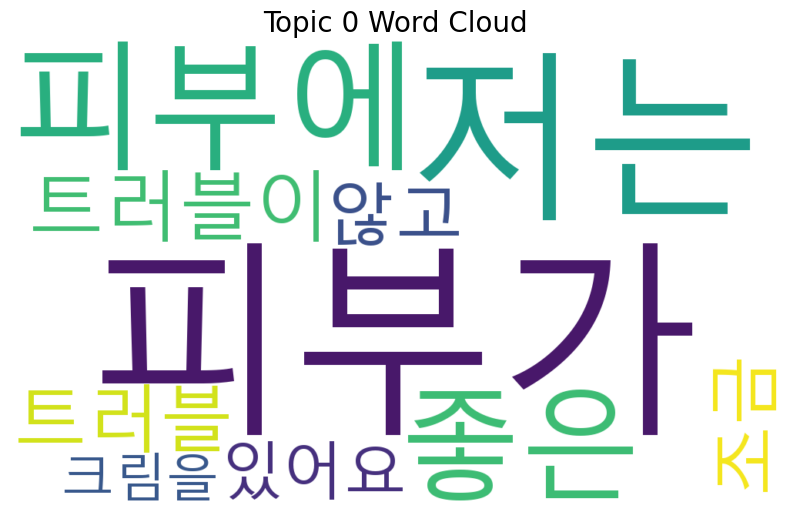

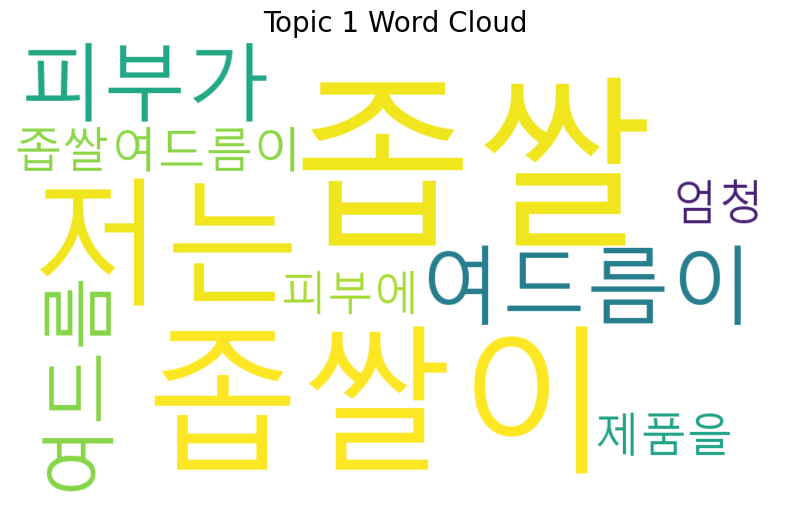

In [8]:
# 1. 라이브러리 설치 (없으면 실행)
!pip install wordcloud

# 2. 한글 폰트 설정 & 워드클라우드 생성
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ⚠️ 주의: 본인 컴퓨터에 있는 한글 폰트 경로를 지정해야 글자가 안 깨집니다.
# 윈도우: "C:/Windows/Fonts/malgun.ttf"
# 맥: "/System/Library/Fonts/AppleSDGothicNeo.ttc"
# 코랩(Colab): 별도 설치 필요 (나눔고딕 등)
FONT_PATH = "C:/Windows/Fonts/malgun.ttf"

def create_wordcloud(topic_model, topic_num):
    text = {word: value for word, value in topic_model.get_topic(topic_num)}

    wc = WordCloud(
        font_path=FONT_PATH,
        background_color="white",
        width=1000,
        height=600
    )
    wc.generate_from_frequencies(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_num} Word Cloud", fontsize=20)
    plt.show()

# 가장 비중이 큰 토픽(Topic 0) 시각화
create_wordcloud(topic_model, 0)
# 두 번째 토픽(Topic 1) 시각화
create_wordcloud(topic_model, 1)